<a href="https://colab.research.google.com/github/Djimdou/Side-Projects/blob/master/Mbay_Songs_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Aim: classification on mbay songs. Given a song in mbay, can we predict its genre?

In [0]:
# Help: 
# 1) https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html
# 2) https://www.analyticsvidhya.com/blog/2017/08/audio-voice-processing-deep-learning/

# Files: https://drive.google.com/drive/folders/0B-znYQjmJbqKTWVGUG9mQVNPZTQ

In [0]:
import librosa

In [0]:
audio_data = "/content/drive/My Drive/Discothèque Mbaye/Autres/A I Ra Ri Kad Nel Dé'g.mp3"

# Need to install ffmpeg. Help here: https://windowsloop.com/install-ffmpeg-windows-10/

x , sr = librosa.load(audio_data)

In [0]:
# Play the audio

import IPython.display as ipd
ipd.Audio(audio_data)

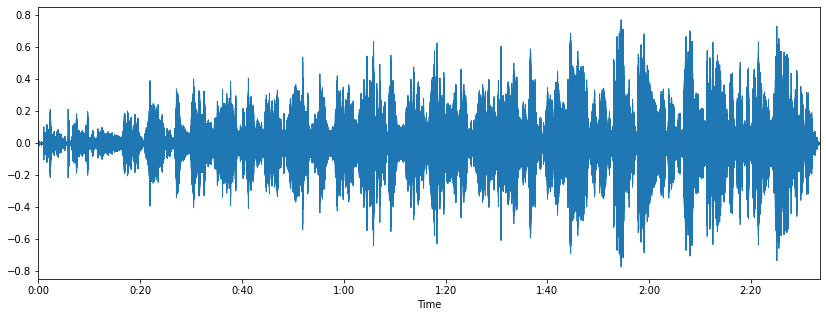

In [0]:
# Display

import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

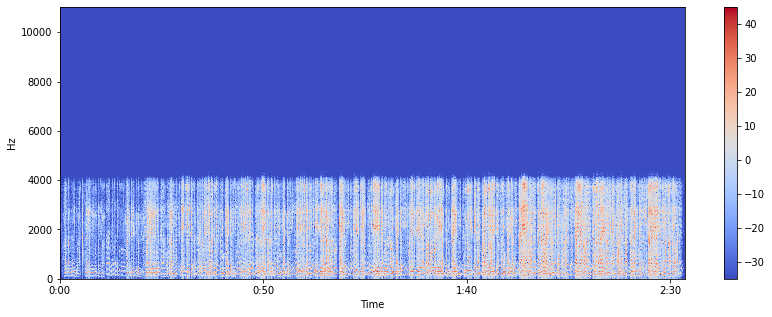

In [0]:
# Spectogram

X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

In [0]:
# # Genre classification

In [1]:
%tensorflow_version 1.x
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras import layers
from keras import layers
import keras
from keras.models import Sequential
import warnings
from sklearn.metrics import classification_report,confusion_matrix
warnings.filterwarnings('ignore')

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
# Extracting spectograms

# cmap = plt.get_cmap('inferno')
# plt.figure(figsize=(8,8))
# genres = 'Bang Klag Lamson'.split() #  --   Autres Baïgn  Terta Non-Yo  Lab Ndo_bessi

#for g in genres:
#    pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True)
#    i=1
#    for filename in os.listdir(f'./drive/My Drive/Discothèque Mbaye/{g}'):
#        songname = f'./drive/My Drive/Discothèque Mbaye/{g}/{filename}'
#        #x, srx = librosa.load(songname, mono=True)
#        y, sr = librosa.load(songname, mono=True,offset=90, duration=15) #librosa.get_duration(x)/2
#        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
#        plt.axis('off');
#       filename = 'chanson' + str(i)
#        plt.savefig(f'img_data/{g}/{filename}.png')
#        plt.clf()
#        i=i+1

# Header for our CSV file

header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

# Extracting features from Spectrogram: Mel-frequency cepstral coefficients (MFCC), Spectral Centroid, Zero Crossing Rate, Chroma Frequencies, and Spectral Roll-off

duree = 30

file = open('dataset_'+str(duree)+'s.csv', 'w', newline='') # 'a' for openning an existing file for writing
with file:
    writer = csv.writer(file,delimiter=';')
    writer.writerow(header)
genres = 'Lamson Klag Bang Baïgn'.split() #     -- Lab Ndo_bessi Bordero Test  Autres Terta Non-Yo
for g in genres:
    i=1
    for filename in os.listdir(f'./drive/My Drive/Discothèque Mbaye/{g}'):
        songname = f'./drive/My Drive/Discothèque Mbaye/{g}/{filename}'
        x, srx = librosa.load(songname, mono=True)
        y, sr = librosa.load(songname, mono=True,offset=librosa.get_duration(x)/2, duration=duree) #librosa.get_duration(x)/2
        rmse = librosa.feature.rmse(y=y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        filename = 'chanson' + str(i)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('dataset_'+str(duree)+'s.csv', 'a', newline='')
        with file:
            writer = csv.writer(file,delimiter=';')
            writer.writerow(to_append.split())
        i=i+1

In [2]:
data = pd.read_csv('dataset_30s.csv', sep=';')
data.head()# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)

# Converting to numeric type
numeric = list(data.columns)
del numeric[-1]
data[numeric] = data[numeric].apply(pd.to_numeric, errors='coerce')

data['label'].unique()
#data[data['label']=='Bordero'].shape

array(['Lamson', 'Klag', 'Bang', 'Baïgn'], dtype=object)

In [3]:
# Encoding the Labels
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)#Scaling the Feature columns
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

# Dividing data into training and Testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(X_train.shape); print(X_test.shape)

(113, 26)
(49, 26)


In [0]:
# # Multi-Layer Perceptron Classifier

# From https://www.pluralsight.com/guides/machine-learning-neural-networks-scikit-learn

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)
mlp.fit(X_train,y_train)

predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)

In [0]:
from sklearn.metrics import classification_report,confusion_matrix

print(confusion_matrix(y_train,predict_train))

[[45  0  0  0]
 [ 2  3  1  0]
 [ 4  0 12  0]
 [ 1  0  0 45]]


In [0]:
print(classification_report(y_train,predict_train))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        45
           1       1.00      0.50      0.67         6
           2       0.92      0.75      0.83        16
           3       1.00      0.98      0.99        46

    accuracy                           0.93       113
   macro avg       0.95      0.81      0.85       113
weighted avg       0.94      0.93      0.92       113



In [0]:
print(confusion_matrix(y_test,predict_test))

[[21  0  0  0]
 [ 1  0  0  1]
 [ 6  1  2  0]
 [ 4  0  1 12]]


In [0]:
print(classification_report(y_test,predict_test))

              precision    recall  f1-score   support

           0       0.66      1.00      0.79        21
           1       0.00      0.00      0.00         2
           2       0.67      0.22      0.33         9
           3       0.92      0.71      0.80        17

    accuracy                           0.71        49
   macro avg       0.56      0.48      0.48        49
weighted avg       0.72      0.71      0.68        49



In [0]:
# Building an ANN model

model = Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model

classifier = model.fit(X_test,
                    y_test,
                    epochs=10,
                    batch_size=128
                    )

Epoch 1/10
49/49 [==============================] - 0s 2ms/step - loss: 2.2837 - accuracy: 0.1429
Epoch 2/10
49/49 [==============================] - 0s 64us/step - loss: 2.1278 - accuracy: 0.4082
Epoch 3/10
49/49 [==============================] - 0s 88us/step - loss: 1.9875 - accuracy: 0.5510
Epoch 4/10
49/49 [==============================] - 0s 53us/step - loss: 1.8563 - accuracy: 0.5918
Epoch 5/10
49/49 [==============================] - 0s 52us/step - loss: 1.7291 - accuracy: 0.7143
Epoch 6/10
49/49 [==============================] - 0s 60us/step - loss: 1.6030 - accuracy: 0.7347
Epoch 7/10
49/49 [==============================] - 0s 46us/step - loss: 1.4780 - accuracy: 0.7551
Epoch 8/10
49/49 [==============================] - 0s 46us/step - loss: 1.3558 - accuracy: 0.7755
Epoch 9/10
49/49 [==============================] - 0s 49us/step - loss: 1.2376 - accuracy: 0.7755
Epoch 10/10
49/49 [==============================] - 0s 54us/step - loss: 1.1252 - accuracy: 0.7755


In [0]:
# Multinomial regression

from sklearn.linear_model import LogisticRegression

multi = LogisticRegression(random_state=0).fit(X_train, y_train)
#clf.predict(X_train)
#clf.predict_proba(X_train)
multi.score(X_train, y_train),multi.score(X_test, y_test)

(0.8584070796460177, 0.7142857142857143)

# Nouvelle section

In [0]:
# # Convolutional Neural Networks on spectograms

In [0]:
# https://levelup.gitconnected.com/audio-data-analysis-using-deep-learning-with-python-part-2-4a1f40d3708d

In [0]:
import pandas as pd
import numpy as np
from numpy import argmax
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import librosa.display
import IPython.display
import random
import warnings
import os
from PIL import Image
import pathlib
import csv
# sklearn Preprocessing
from sklearn.model_selection import train_test_split
#Keras
import keras
import warnings
warnings.filterwarnings('ignore')
from keras import layers
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add
from keras.models import Sequential
from keras.optimizers import SGD

In [0]:
# # K-Nearest Neighbors

# https://scikit-learn.org/stable/modules/neighbors.html#classification
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py

from sklearn import neighbors, datasets

n_neighbors = 10
nghbs = neighbors.KNeighborsClassifier(n_neighbors).fit(X_train, y_train)
nghbs.score(X_train, y_train),nghbs.score(X_test, y_test)

(0.6283185840707964, 0.6530612244897959)

In [6]:
# # Support Vector Machines

from sklearn import svm

SVM_model = svm.SVC()#(kernel='linear')
SVM_model.fit(X_train,y_train)
#svm.SVC()

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [10]:
print(classification_report(y_train,SVM_model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88        47
           1       0.00      0.00      0.00         5
           2       0.90      0.47      0.62        19
           3       0.95      0.98      0.96        42

    accuracy                           0.86       113
   macro avg       0.66      0.61      0.62       113
weighted avg       0.83      0.86      0.83       113



In [9]:
print(classification_report(y_test,SVM_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.64      0.84      0.73        19
           1       0.00      0.00      0.00         3
           2       1.00      0.17      0.29         6
           3       0.83      0.90      0.86        21

    accuracy                           0.73        49
   macro avg       0.62      0.48      0.47        49
weighted avg       0.72      0.73      0.69        49



In [16]:
# # Decision Tree Classifiers/Random Forests

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

ForAlea = RandomForestClassifier(max_depth=2, random_state=0)
y_pred = ForAlea.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.53      0.84      0.65        19
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         6
           3       0.79      0.71      0.75        21

    accuracy                           0.63        49
   macro avg       0.33      0.39      0.35        49
weighted avg       0.55      0.63      0.57        49



In [17]:
# # Naive Bayes

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.63      0.63      0.63        19
           1       0.33      0.33      0.33         3
           2       0.33      0.33      0.33         6
           3       0.71      0.71      0.71        21

    accuracy                           0.61        49
   macro avg       0.50      0.50      0.50        49
weighted avg       0.61      0.61      0.61        49



In [19]:
# # Linear Discriminant Analysis

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

LinDis = LinearDiscriminantAnalysis()
y_pred = LinDis.fit(X_train, y_train).predict(X_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.84      0.62      0.71        26
           1       0.33      1.00      0.50         1
           2       0.17      1.00      0.29         1
           3       0.71      0.71      0.71        21

    accuracy                           0.67        49
   macro avg       0.51      0.83      0.55        49
weighted avg       0.76      0.67      0.70        49

